In [28]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error 
from defs import print_timeseries_metrics, plot_per_day, plot_compare_results
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

Melhor: com holidays e future_covariates. com/sem past_covariates (0/3)

In [29]:
from darts import TimeSeries
from darts.metrics import mape, mae

In [30]:
np.random.seed(1234)

## Pré-processamento

In [31]:
df0 = pd.read_pickle('data/interim/entrada_ui.pickle')
internados = pd.read_pickle('data/interim/internados_ui_.pickle')
fim_ano = pd.read_pickle('data/interim/fim_ano.pickle')
after_holidays = pd.read_pickle('data/interim/after_holidays.pickle')
holidays = pd.read_pickle('data/interim/holidays.pickle')

## Gráficos (número de internados por dia e médias móveis)

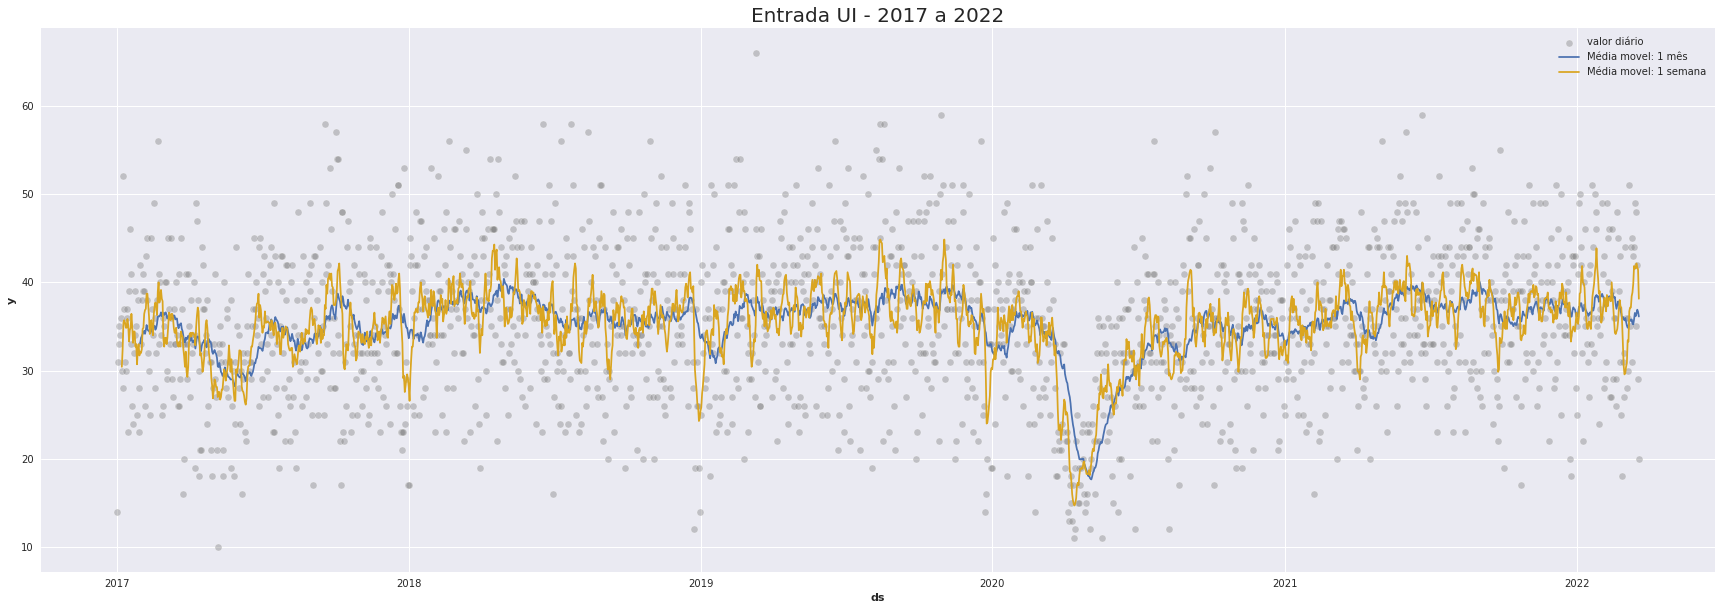

In [32]:
plot_per_day(df0, 'Entrada UI - 2017 a 2022')

In [33]:
df0['y'].describe()

count    1905.000000
mean       35.290289
std         8.643635
min        10.000000
25%        30.000000
50%        35.000000
75%        41.000000
max        66.000000
Name: y, dtype: float64

## Modelo


In [34]:
series = TimeSeries.from_dataframe(df0, 'ds', 'y')
val_date = '20211001'
train, val = series.split_before(pd.Timestamp(val_date))
# start_date = pd.Timestamp(val_date.replace(val_date[:4], str(int(val_date[:4]) - 1)))
start_date = pd.Timestamp('20210101')

covariates = after_holidays.merge(fim_ano, on='ds')
covariates = covariates.merge(internados, on='ds')
covariates_series = TimeSeries.from_dataframe(covariates, 'ds', ['after_holidays', 'fim_ano', 'n_internados'])

### Exponential Smoothing

In [8]:
from darts.models import ExponentialSmoothing
model_es = ExponentialSmoothing(random_state=42)

Importing plotly failed. Interactive plots will not work.


In [9]:
historical_forecasts_es_list = model_es.historical_forecasts(series = series,
                            start=start_date,
                            forecast_horizon=1,
                            last_points_only=False,                            
                            stride=1,
                            verbose=True)

  0%|          | 0/432 [00:00<?, ?it/s]

In [10]:
historical_forecasts_es_list = [hf.pd_dataframe() for hf in historical_forecasts_es_list]
historical_forecasts_es = pd.DataFrame()
for hf in historical_forecasts_es_list:
    historical_forecasts_es = historical_forecasts_es.append(hf)
historical_forecasts_es.columns = ['y_pred_ExponentialSmoothing']

In [11]:
df_es = historical_forecasts_es.merge(df0, left_on='ds', right_on='ds')
print_timeseries_metrics(df_es, 'y_pred_ExponentialSmoothing')

Absolute percentage error - Percentil 90%:  30.736%
Absolute percentage error - Percentil 95%:  40.816%
Absolute error - Percentil 90%:  10.000
Absolute error - Percentil 95%:  12.000
Mape: 14.500%
Mae: 4.961
       abs_error_y_pred_ExponentialSmoothing  ape_y_pred_ExponentialSmoothing
count                             432.000000                       432.000000
mean                                4.960648                         0.145000
std                                 3.857776                         0.135732
min                                 0.000000                         0.000000
25%                                 2.000000                         0.051282
50%                                 4.000000                         0.111111
75%                                 7.000000                         0.200000
max                                18.000000                         0.900000


In [12]:
model_es.fit(train)
mape(val, model_es.predict(7))

20.67985570028711

### Prophet

In [35]:
outros = {}

future_covariates_cols = ['after_holidays', 'fim_ano']
# future_covariates_cols = None
if future_covariates_cols:
    future_covariates = covariates_series[future_covariates_cols]
else:
    future_covariates = None


past_covariates = covariates_series['n_internados']
# past_covariates = None

# country_holidays = holidays.copy()
country_holidays = None

outros['holidays'] = True if type(country_holidays) == pd.core.frame.DataFrame else False
outros['future_covariates'] = future_covariates_cols
outros['past_covariates'] = True if past_covariates != None else False

In [14]:
from darts.models import Prophet
model_pr = Prophet(weekly_seasonality = True, daily_seasonality=False, yearly_seasonality=True, holidays=country_holidays)

In [15]:
historical_forecasts_pr_list = model_pr.historical_forecasts(series = series,
                                                             start=start_date,
                                                             forecast_horizon=1,
                                                             last_points_only=False,                            
                                                             stride=1,
                                                             future_covariates=future_covariates,
                                                             past_covariates=past_covariates,
                                                             verbose=True)

  0%|          | 0/432 [00:00<?, ?it/s]

In [16]:
historical_forecasts_pr_list = [hf.pd_dataframe() for hf in historical_forecasts_pr_list]
historical_forecasts_pr = pd.DataFrame()
for hf in historical_forecasts_pr_list:
    historical_forecasts_pr = historical_forecasts_pr.append(hf)
historical_forecasts_pr.columns = ['y_pred_Prophet']

In [17]:
df_pr = historical_forecasts_pr.merge(df_es, left_on='ds', right_on='ds')
print_timeseries_metrics(df_pr, 'y_pred_Prophet')

Absolute percentage error - Percentil 90%:  33.333%
Absolute percentage error - Percentil 95%:  45.464%
Absolute error - Percentil 90%:  11.000
Absolute error - Percentil 95%:  14.000
Mape: 15.668%
Mae: 5.250
       abs_error_y_pred_Prophet  ape_y_pred_Prophet
count                432.000000          432.000000
mean                   5.250000            0.156683
std                    4.055588            0.149782
min                    0.000000            0.000000
25%                    2.000000            0.052632
50%                    4.000000            0.113636
75%                    8.000000            0.212121
max                   18.000000            1.000000


In [18]:
time_pos = covariates.loc[covariates['ds'] == val_date].index[0] - len(covariates)
model_pr.fit(train)
if future_covariates_cols:
    pred = model_pr.predict(7, future_covariates=covariates_series[time_pos:time_pos+7])
else:
    pred = model_pr.predict(7)
mape(val, pred)

22.987849918168894

### TFT

In [117]:
# from darts.models import TFTModel
# model_tft.reset_model()
# model_tft = TFTModel(input_chunk_length=730, output_chunk_length=1, random_state=42, n_epochs=1)

In [118]:
# model_tft.fit(train, future_covariates=future_covariates, past_covariates=past_covariates)
# pred = model_tft.predict(1, future_covariates=future_covariates, past_covariates=past_covariates)

# mape(val, pred)

## Compare

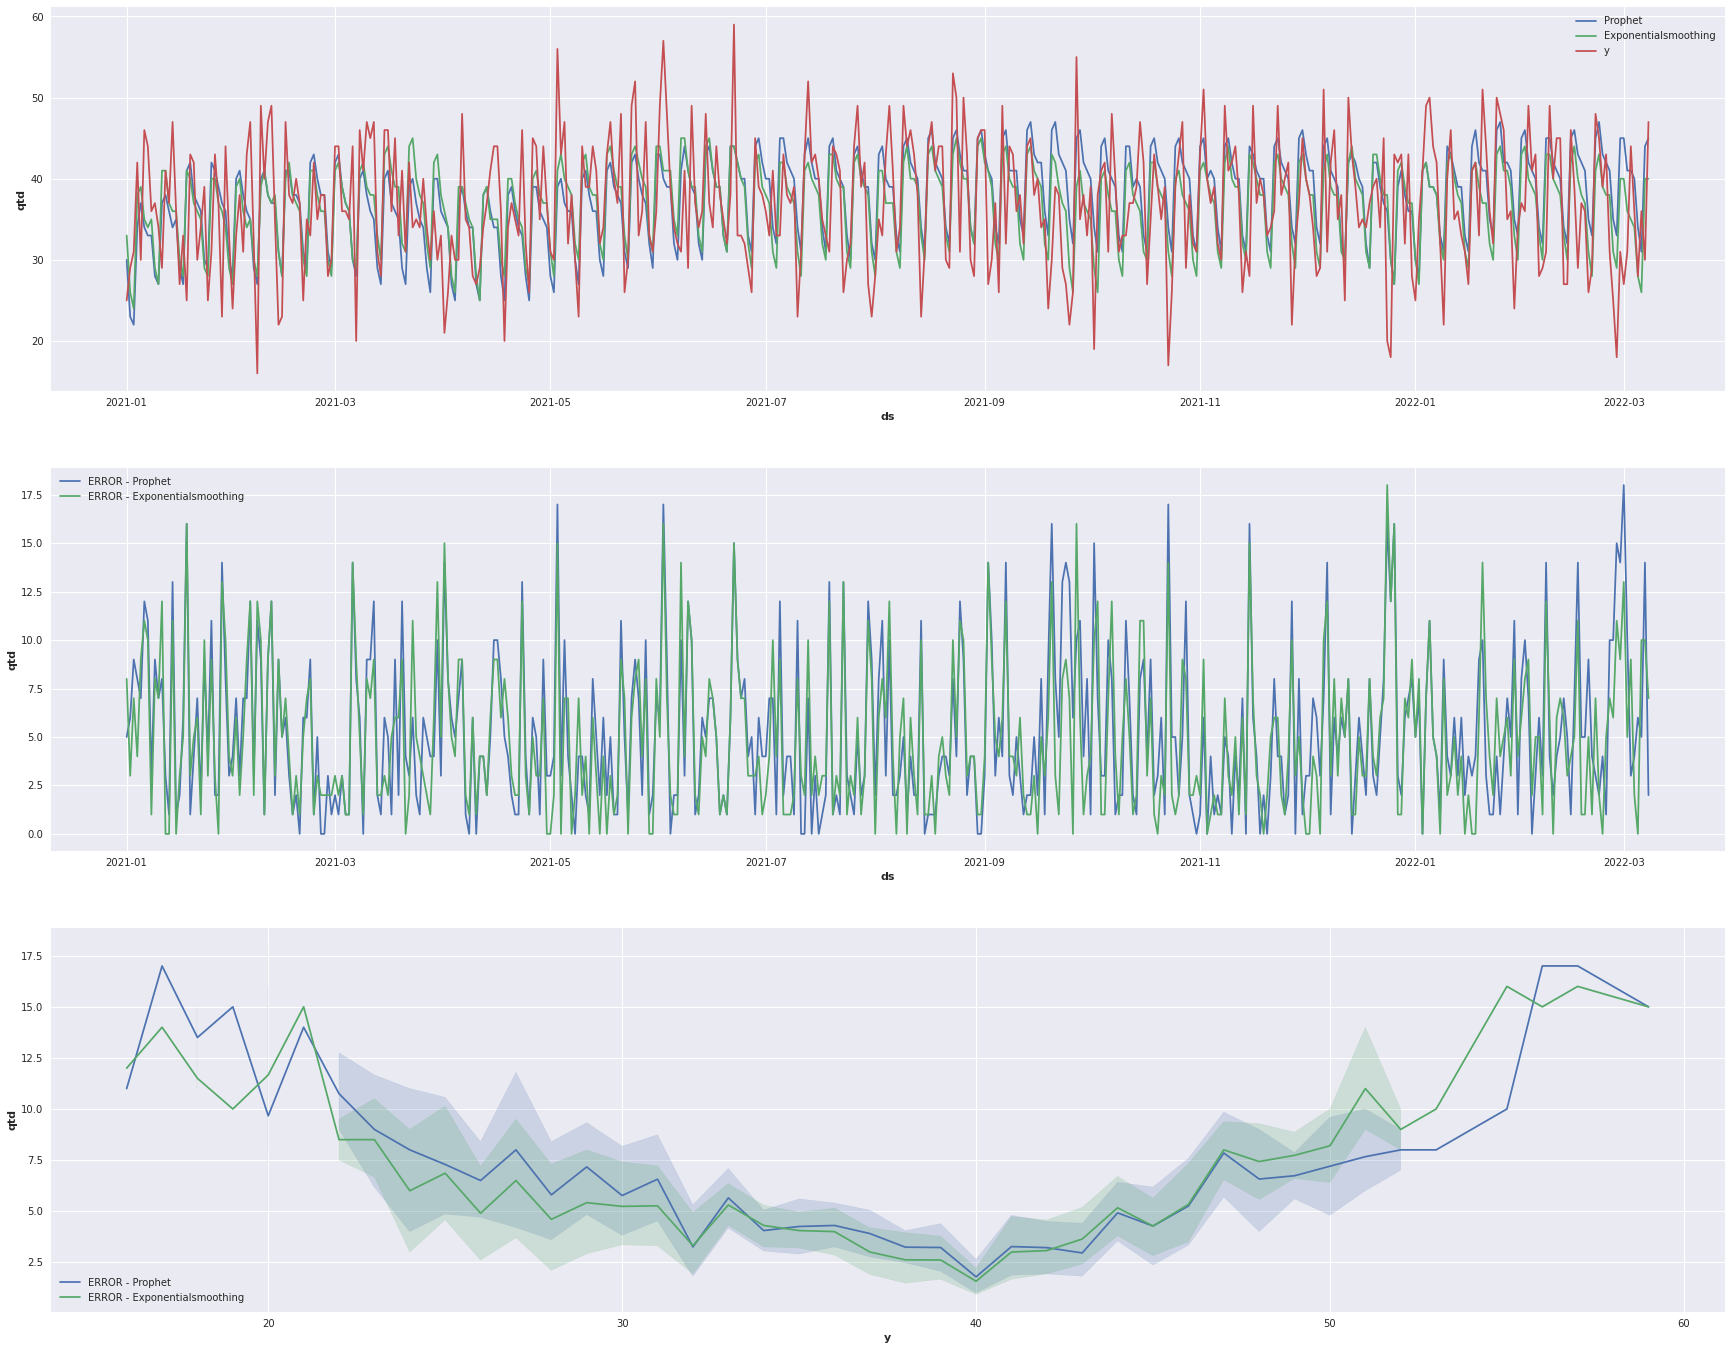

In [19]:
plot_compare_results(df_pr, 'y_pred_Prophet', 'y_pred_ExponentialSmoothing')

## Ensemble

In [40]:
df1 = df_pr.merge(covariates)
df1['dayofweek'] = df1['ds'].dt.dayofweek

df1['ensemble1'] = (df1['y_pred_Prophet']+df1['y_pred_ExponentialSmoothing'])/2
df1['ensemble2'] = (df1['y_pred_Prophet']+df1['y_pred_ExponentialSmoothing']*2)/3
df1['ensemble3'] = (df1['y_pred_Prophet']+df1['y_pred_ExponentialSmoothing']*3)/4
df1['ensemble4'] = (df1['y_pred_Prophet']+df1['y_pred_ExponentialSmoothing']*4)/5
df1['ensemble5'] = np.sqrt(df1['y_pred_Prophet']*df1['y_pred_ExponentialSmoothing'])
df1['ensemble6'] = np.cbrt(df1['y_pred_Prophet']*df1['y_pred_ExponentialSmoothing']**2)
df1['ensemble7'] = np.cbrt(df1['y_pred_Prophet']**2*df1['y_pred_ExponentialSmoothing'])
df1['ensemble8'] = (df1['y_pred_Prophet']*2+df1['y_pred_ExponentialSmoothing'])/3
df1['ensemble9'] = (df1['y_pred_Prophet']*3+df1['y_pred_ExponentialSmoothing'])/4
df1['ensemble10'] = (df1['y_pred_Prophet']*4+df1['y_pred_ExponentialSmoothing'])/5

addSegunda = 0
addTerca = 1
subSabado = 0
subDomingo = 0
addAfterHolidays = 0
subFimAno = 0

outros['addSegunda'] = addSegunda
outros['addTerca'] = addTerca
outros['subSabado'] = subSabado
outros['subDomingo'] = subDomingo
outros['addAfterHolidays'] = addAfterHolidays
outros['subFimAno'] = subFimAno

for ensemble_col in [c for c in df1.columns if ('pred' in c) or ('ensemble' in c)]:
    df1[f'{ensemble_col}_weekday'] = df1[ensemble_col].copy()
    df1.loc[df1['dayofweek'] == 0,f'{ensemble_col}_weekday'] = df1.loc[df1['dayofweek'] == 0,f'{ensemble_col}_weekday'] + addSegunda
    df1.loc[df1['dayofweek'] == 1,f'{ensemble_col}_weekday'] = df1.loc[df1['dayofweek'] == 1,f'{ensemble_col}_weekday'] + addTerca
    df1.loc[df1['after_holidays'] == 1,f'{ensemble_col}_weekday'] = df1.loc[df1['after_holidays'] == 1, f'{ensemble_col}_weekday'] + addAfterHolidays
    df1.loc[df1['dayofweek'] == 5,f'{ensemble_col}_weekday'] = df1.loc[df1['dayofweek'] == 5,f'{ensemble_col}_weekday'] - subSabado
    df1.loc[df1['dayofweek'] == 6,f'{ensemble_col}_weekday'] = df1.loc[df1['dayofweek'] == 6,f'{ensemble_col}_weekday'] - subDomingo
    df1.loc[df1['fim_ano'] == 1,f'{ensemble_col}_weekday'] = df1.loc[df1['fim_ano'] == 1, f'{ensemble_col}_weekday'] - subFimAno
    

In [41]:
menor_mae = 10
for col in [c for c in df1.columns if ('pred' in c) or ('ensemble' in c)]:
    mae_ = mean_absolute_error(df1['y'], df1[col].round(0).astype(int))
    mape_ = mean_absolute_percentage_error(df1['y'], df1[col].round(0).astype(int))
    if mae_ < menor_mae:
        menor_mae = mae_
        menor_mape = mape_
        melhor_col = col
print(melhor_col, menor_mae, menor_mape)
outros['melhor_coluna'] = melhor_col

y_pred_ExponentialSmoothing_weekday 4.951388888888889 0.1451783792120354


<AxesSubplot:xlabel='y', ylabel='erros'>

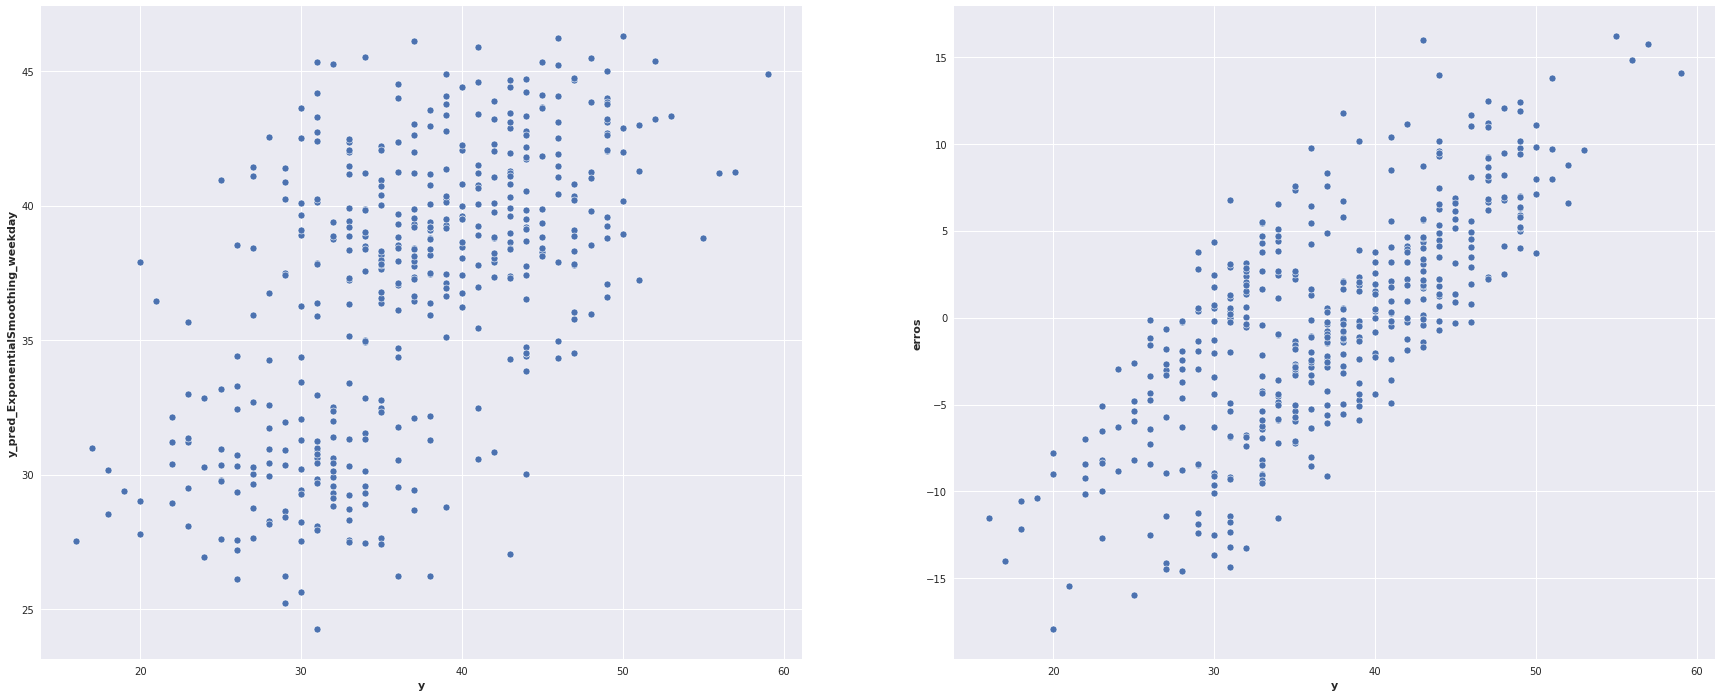

In [42]:
import seaborn as sns
import matplotlib.pyplot as plt

df1['erros'] = df1['y']-df1[melhor_col]
fig_dims = (30, 12)
fig, ax = plt.subplots(1,2, figsize=fig_dims)
sns.scatterplot(data = df1, x='y', y=melhor_col, ax=ax[0])
sns.scatterplot(data = df1, x='y', y='erros', ax=ax[1])

In [45]:
df2 = df1[['y', melhor_col]].copy()
print_timeseries_metrics(df2, melhor_col, register_results=True, modelo='EntradaUi', outros=outros)   

Absolute percentage error - Percentil 90%:  31.498%
Absolute percentage error - Percentil 95%:  41.121%
Absolute error - Percentil 90%:  10.000
Absolute error - Percentil 95%:  12.000
Mape: 14.518%
Mae: 4.951
       abs_error_y_pred_ExponentialSmoothing_weekday  \
count                                     432.000000   
mean                                        4.951389   
std                                         3.891206   
min                                         0.000000   
25%                                         2.000000   
50%                                         4.000000   
75%                                         7.000000   
max                                        18.000000   

       ape_y_pred_ExponentialSmoothing_weekday  
count                               432.000000  
mean                                  0.145178  
std                                   0.137068  
min                                   0.000000  
25%                                   0.0

In [ ]:
outros

{'holidays': True,
 'future_covariates': ['after_holidays', 'fim_ano'],
 'past_covariates': False,
 'addSegunda': 0,
 'addTerca': 0,
 'subSabado': 1,
 'subDomingo': 0,
 'addAfterHolidays': 0,
 'subFimAno': 0,
 'melhor_coluna': 'ensemble2_weekday'}